# Model run: Calibration 
Use this notebook to run and evaluate a parameter grid-search. 

This notebook can be run after 0, 1, and 2. We recommend also running 3a first, to check for and troubleshoot issues.

In [1]:
import os
import dotenv
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Set up workspace from env and configuration files 

In [2]:
# Navigate one level up to the main repository
os.chdir('..')

In [3]:
# Read environmental variables
env_file = os.path.join('.env') 
dotenv.load_dotenv(env_file)

input_dir = os.getenv('INPUT_PATH')
out_dir = os.getenv('OUTPUT_PATH')
path_to_config_json = os.getenv('CONFIG_PATH')


In [4]:
with open(path_to_config_json) as json_file:
    config = json.load(json_file)

sim_name = config['sim_name']
add_descript = config["add_descript"]

run_name = sim_name + add_descript
total_runs = config["run_count"] 


In [6]:
run_name = "slf_grid_agg"

## Run Model in parallel

In [ ]:
# How many nodes to dedicate to model? (default = 4)

In [ ]:
# Here the model runs from script 
# This run should not use forecasted data



# Write files out to: outdir/run_name_calibrate


In [ ]:
# Calculate summary statistics

!python pandemic/multirun_helpers/get_stats.py calibrate

## Evaluate grid performance
F-beta is the primary metric used to evaluate model run performance.

Use the below to visualize and assess the....

In [17]:
stats_dir = f"{out_dir}/summary_stats/{run_name}" #_calibrate"

validation_df = pd.read_csv(
        input_dir + "/first_records_validation.csv",
        header=0,
        index_col=0,
    )

col_dict = {"start_max":"start","alpha_max":"alpha","beta_max":"beta",
    "lamda_max":"lamda","count_known_countries_time_window_fbeta_mean":"fbeta"}

agg_df = (
    pd.read_csv(f"{stats_dir}/summary_stats_bySample.csv")
    .rename(columns=col_dict)
    )
stats = (pd.read_csv(f"{stats_dir}/summary_stats_wPrecisionRecallF1FBetaAggProb.csv")
.rename(columns=col_dict)
)

### Data visualization 

- Assess run convergence: Evaluate the top performing parameter samples to see if the F-beta score has converged. If it hasn't converged, you need to conduct more runs. You can include additional runs by updating the start_run (to continue after previous end_run), end_run, and run_count. 
- Assess parameter set performance: Visualize F-beta across values for alpha, lamda, beta, and start year. Highest performing values should generally cluster towards a limited range for each parameter. If the highest performing values are at an extreme of a parameter range (e.g. at the highest end of lamda, at the earliest year), you may need to expand your grid search. 

#### Assess run convergence

In [24]:
# Top N runs

n_runs = 20

top_runs = agg_df.sort_values('fbeta',ascending=False).head(n_runs)
fbeta_range = [min(top_runs.fbeta)*0.75, max(top_runs.fbeta)*1.25]

In [19]:
samples = list(agg_df.sort_values('fbeta',ascending=False).head(n_runs).reset_index()['sample'])
runs = list(range(0,stats['run_num'].max()))

samples_df = pd.DataFrame({'runs':runs})
i=1
for sample in samples:
    sample_fbeta = []
    stdev = []
    sterr = []
    for run in runs:
        filtered_stats = stats.loc[(stats['run_num']<=run) & (stats['sample']==sample)]
        value = filtered_stats["count_known_countries_time_window_fbeta"].mean()
        sdev = filtered_stats["count_known_countries_time_window_fbeta"].std() 
        # this gives the standard deviation of the sample - mean
        sample_fbeta.append(value)
        stdev.append(sdev)
        sterr.append(np.std(sample_fbeta)) 
        # this gives the standard error of the mean
    samples_df[f"sample {i}"]=sample_fbeta
    samples_df[f"stdev {i}"]=stdev
    samples_df[f"sterr {i}"]=sterr
    i += 1

samples_df.set_index("runs",inplace=True)    
samples_df["all samples"]=samples_df.mean(axis=1)


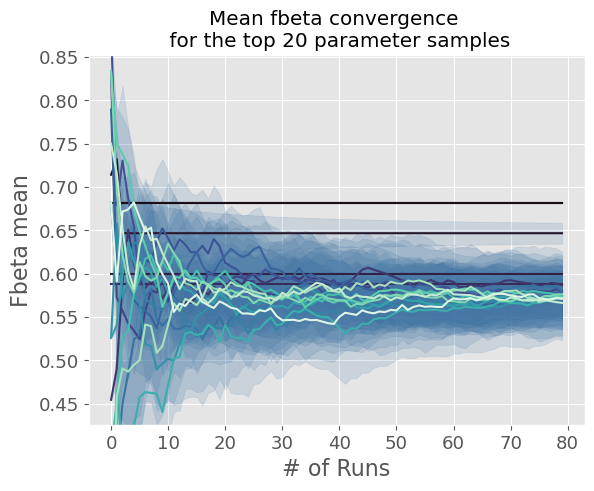

In [25]:
plt.style.use('ggplot')

ax = (samples_df.loc[:,'sample 1':f'sample {n_runs}':3]
    .plot(ylim=fbeta_range,cmap="mako",ylabel="fbeta",
    title="Mean fbeta convergence \n for the top 20 parameter samples",
    legend=False))
for i in range(1, len(samples)):
    ax.fill_between(samples_df.index, samples_df[f"sample {i+1}"]+samples_df[f"sterr {i+1}"], samples_df[f"sample {i+1}"]-samples_df[f"sterr {i+1}"],color='#366da0',alpha=0.15)
ax.set_xlabel("# of Runs",fontsize=16)
ax.set_ylabel("Fbeta mean",fontsize=16)
ax.tick_params(labelsize=13)
plt.show()

#### Assessing parameter set performance 

In [ ]:
sns.set_context(font_scale=5)

In [ ]:
ax = sns.stripplot(x='alpha', y='fbeta', hue='start', palette='mako',linewidth=0.2, data=agg_df, jitter=0.4)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.25,1), loc='upper right', borderaxespad=0,title="start year")
ax.set(ylim=(0,1))
ax.axes.set_title("Mean Sample Fbeta, by Alpha Value\n (Color = Year)",fontsize=16)
ax.set_xlabel("Alpha",fontsize=16)
ax.set_ylabel("Fbeta mean",fontsize=16)
ax.tick_params(labelsize=13)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.show()


In [ ]:
ax = sns.scatterplot(x='lamda',y='fbeta',hue='start',data=agg_df,palette='mako',edgecolor="black",linewidth=0.2,legend='full') 
ax.set(ylim=(0, 1))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.25,1), loc='upper right', borderaxespad=0,title="start year")
ax.axes.set_title("Mean Sample Fbeta, by Lambda Value\n (Color = Year)",fontsize=16)
ax.set_xlabel("Lambda",fontsize=16)
ax.set_ylabel("Fbeta mean",fontsize=16)
ax.tick_params(labelsize=13)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.show()


In [ ]:
ax = sns.stripplot(x='start', y='fbeta', hue='alpha', palette='mako',linewidth=0.2, data=agg_df, jitter=0.3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.25,1), loc='upper right', borderaxespad=0,title="alpha")
ax.set(ylim=(0,1))
ax.axes.set_title("Mean Sample Fbeta, by Start Year\n (Color = Alpha)",fontsize=16)
ax.set_xlabel("Start year",fontsize=16)
ax.set_ylabel("Fbeta mean",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.show()

## Next: Model run - Forecast

If you are satisfied with the convergence and the parameter performance in the range of your grid, you can use these values to fit a parameter distribution that will be sampled from to conduct the forecast. 